# Net Primary Productivity

In this notebook I’m going to recreate the Net Primary Productivity (NPP) calculations found in the supplemental material for _[Assessing the comparative productivity advantage of bioenergy feedstocks at different latitudes](https://doi.org/10.1088/1748-9326/7/4/045906)_ by Carlisle, Ford, Runge, _et al_. Calculating the NPP for an area is necessary as part determining the comparative advantage of growing crops in that location versus allowing the natural ecosystem to grow.

Net Primary Productivity is the net rate at which plants absorb carbon. The Miami model (_Lieth_, 1973) calculates NPP based on temperature and precipitation in an area.

\begin{equation*}
NPP(Temp, Precip) = \min(\frac{a}{1 + exp(b - c \times Temp))}, d(1 - exp(e \times Precip))
\end{equation*}

For the parameters $a$, $b$, $c$, $d$, and $e$, we’ll use the values provided by [_Zaks_, 2007](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2006GB002705).

\begin{align}
a & = 0.5 \\
b & = 3.75 \\
c & = 6.34 \\
d & = 7.5 \\
e & = -0.13
\end{align}

In [1]:
import math
import sys

import altair as alt
import numpy as np
import pandas as pd
import xarray as xr

sys.path.append("../src")

import npp

In [2]:
zaks_miami = npp.Miami(0.5, 3.75, 6.34, 7.5, -0.13)

## Temperature & Precipitation Data

The temperature and precipitation data come from the [Climatic Research Unit](https://crudata.uea.ac.uk/cru/data/hrg/). I’m using CRU TS v. 4.01, which was updated on 20 September 2017 (Harris, Jones, Osborn, and Lister, 2014).

In [3]:
temperature = xr.open_dataset("../data/cru_ts4.01.1901.2016.tmp.dat.nc")
temperature = temperature.sel(time=slice("1967", "2016"))
temperature.tmp.units

'degrees Celsius'

In [4]:
temperature.tmp.to_dataframe().describe()

,tmp
count,4.045200e+07
mean,8.576043e+00
std,1.788771e+01
min,-5.700000e+01
25%,-2.700000e+00
50%,1.270000e+01
75%,2.390000e+01
max,3.950000e+01


In [5]:
data = temperature.tmp.mean(dim="time").to_dataframe().dropna().reset_index()
data.to_json("../data/plots/mean_temp.json", orient="records")

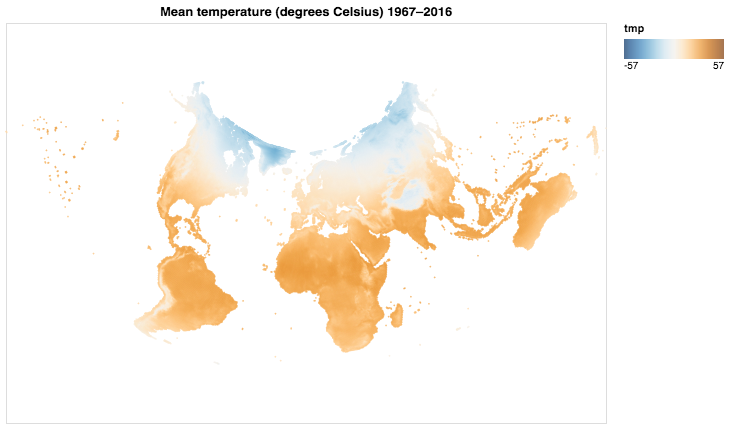

In [6]:
domain = max(abs(float(temperature.tmp.min())), abs(float(temperature.tmp.max())))

alt.Chart(
    "../data/plots/mean_temp.json",
    title="Mean temperature ({}) 1967–2016".format(temperature.tmp.attrs["units"])
).mark_circle(size=3).encode(
    longitude="lon:Q",
    latitude="lat:Q",
    color=alt.Color(
        field="tmp",
        type="quantitative",
        scale=alt.Scale(domain=[-domain, domain], scheme="blueorange"))
).project(
    type="conicEqualArea"
).properties(
    width=600,
    height=400
)

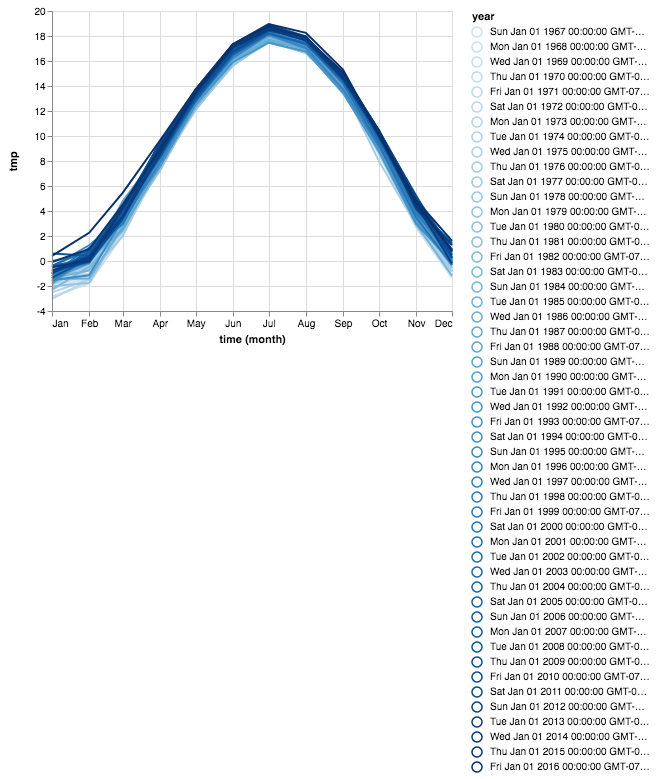

In [7]:
data = temperature.tmp.mean(dim=["lat", "lon"]).to_dataframe().dropna().reset_index()
alt.Chart(data).mark_line().encode(
    alt.X("time:T", timeUnit="month"),
    y="tmp:Q",
    color="year:O"
).transform_timeunit(
    "year", field="time", timeUnit="year"
)

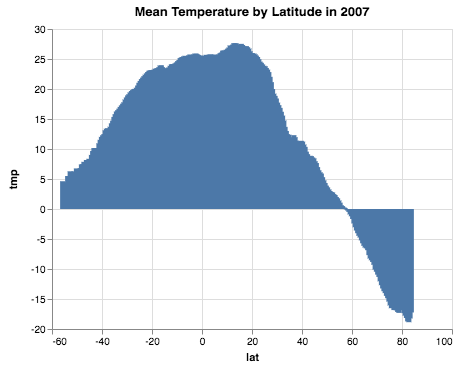

In [8]:
data = temperature.sel(time="2007").tmp.mean(dim=["lon", "time"]).to_dataframe().dropna().reset_index()
alt.Chart(data, title="Mean Temperature by Latitude in 2007").mark_bar().encode(
    x="lat:Q",
    y="tmp:Q"
)

In [9]:
precipitation = xr.open_dataset("../data/cru_ts4.01.1901.2016.pre.dat.nc")
precipitation = precipitation.sel(time=slice("1967", "2016"))
precipitation.pre.units

'mm/month'

In [10]:
data = (precipitation.pre.sum(dim="time") / np.unique(precipitation.time.dt.year).size).to_dataframe(name="pre").reset_index().dropna()
data[data["pre"] > 0].to_json("../data/plots/mean_precipitation.json", orient="records")

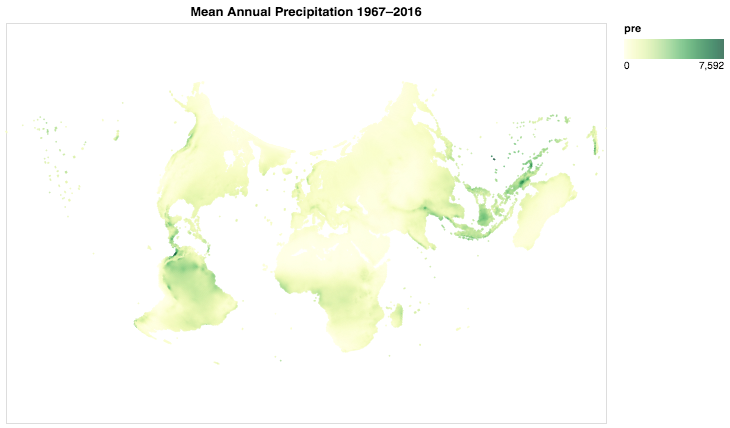

In [11]:
alt.Chart(
    "../data/plots/mean_precipitation.json",
    title="Mean Annual Precipitation 1967–2016"
).mark_circle(size=3).encode(
    longitude="lon:Q",
    latitude="lat:Q",
    color=alt.Color(field="pre", type="quantitative", scale=alt.Scale(scheme="yellowgreen"))
).project(
    type="conicEqualArea"
).properties(
    width=600,
    height=400
)

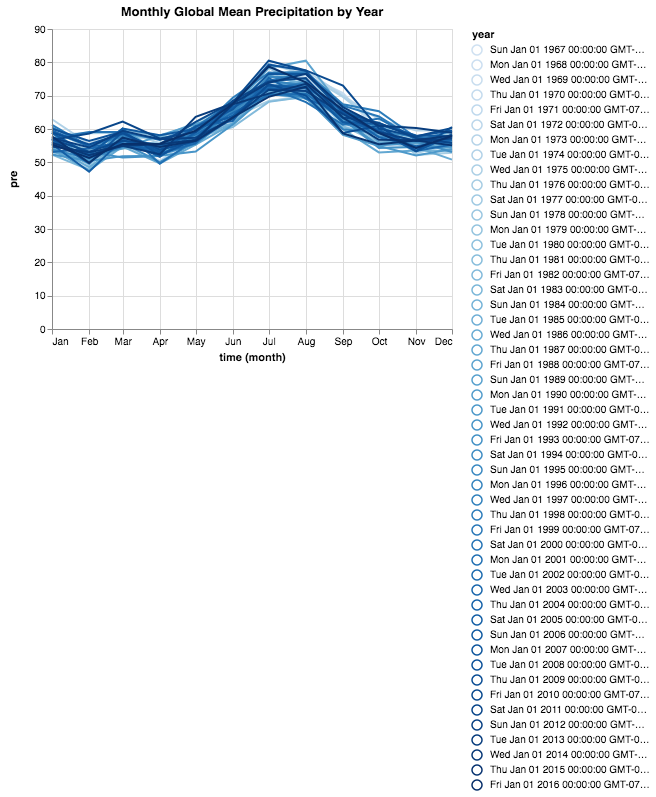

In [12]:
data = precipitation.pre.mean(dim=["lat", "lon"]).to_dataframe().dropna().reset_index()
alt.Chart(data, title="Monthly Global Mean Precipitation by Year").mark_line().encode(
    alt.X("time:T", timeUnit="month"),
    alt.Y("pre:Q"),
    alt.Color("year:O")
).transform_timeunit(
    "year", field="time", timeUnit="year"
)

## Mapping NPP

Let's take a look at NPP around the globe using the temperature and precipitation data above, and the coefficients taken from _Zaks, 2007_.

In [13]:
net_productivity = zaks_miami(
    temperature.tmp.mean(dim="time"),
    precipitation.pre.sum(dim="time") / np.unique(precipitation.time.dt.year).size
)

In [14]:
data = net_productivity.to_dataframe(name="npp").dropna().reset_index()
data[data["npp"] > 0].to_json("../data/plots/zaks_miami_npp.json", orient="records")

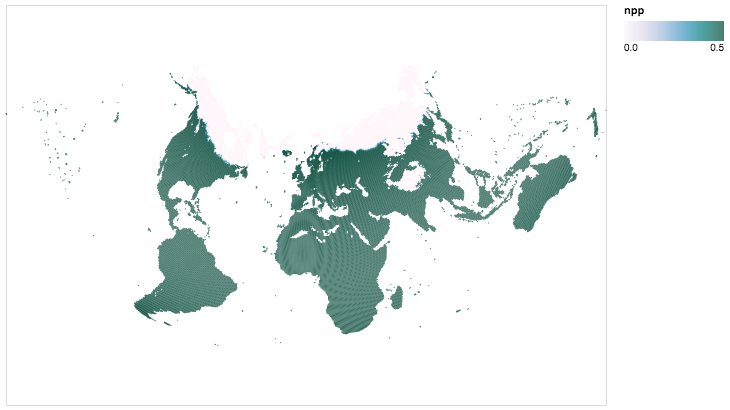

In [15]:
alt.Chart("../data/plots/zaks_miami_npp.json").mark_circle(size=1).encode(
    latitude="lat:Q",
    longitude="lon:Q",
    color=alt.Color("npp:Q", scale=alt.Scale(scheme="purplebluegreen"))
).project(
    type="conicEqualArea"
).properties(
    width=600,
    height=400
)

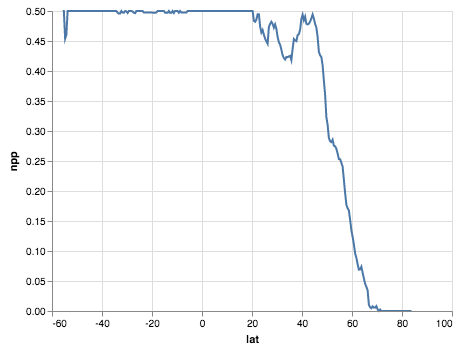

In [16]:
data = (net_productivity).mean(dim="lon").to_dataframe(name="npp").dropna().reset_index()
alt.Chart(data).mark_line().encode(
    x="lat",
    y="npp"
)

This data looks very wrong. Up until about 20º latitude, NPP is completely dominated by temperature, and then it suddenly drops. Also, the order of magnitude of these values seems completely wrong for a calculation that ought to be yielding $\frac{gC}{m^2}$; the values ought to be in the hundreds at least.

### Original Miami Model

For comparison, let's check how NPP looks using the original parameters for the Miami model.

In [17]:
# These constants come from this reference http://www.juergen-grieser.de/downloads/NetPrimaryProduction/npp_miami.pdf
miami = npp.Miami()
net_productivity = miami(
    temperature.tmp.mean(dim=["time"]),
    precipitation.pre.sum(dim=["time"]) / np.unique(precipitation.time.dt.year.data).size
)

In [18]:
data = net_productivity.to_dataframe(name="npp").dropna().reset_index()
data[data["npp"] > 0].to_json("../data/plots/miami_npp.json", orient="records")

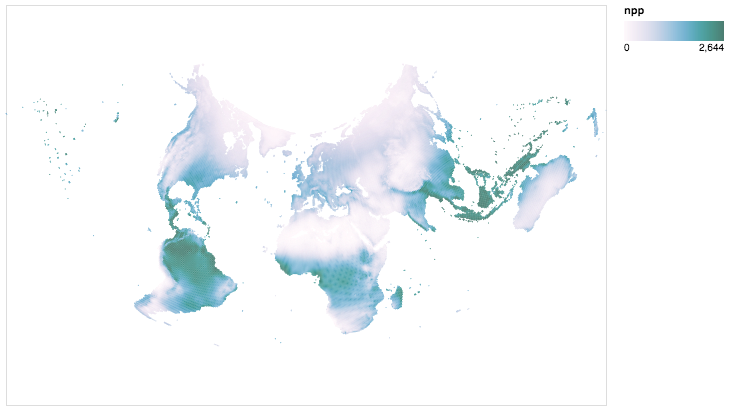

In [19]:
alt.Chart("../data/plots/miami_npp.json").mark_circle(size=1).encode(
    latitude="lat:Q",
    longitude="lon:Q",
    color=alt.Color("npp:Q", scale=alt.Scale(scheme="purplebluegreen"))
).project(
    type="conicEqualArea"
).properties(
    width=600,
    height=400
)

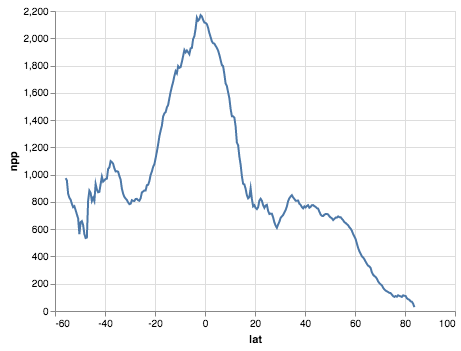

In [20]:
data = net_productivity.mean(dim="lon").to_dataframe(name="npp").dropna().reset_index()
alt.Chart(data).mark_line().encode(
    x="lat:Q",
    y="npp:Q"
)

These values look much better. I'm not sure what's going wrong with the parameters from _Zaks, 2007_. It could be that the values are wrong, or that I'm applying them to the model incorrectly, but applying the original parameters in the same way yields far more believable results.

## National Center for Ecological Analysis and Synthesis (NCEAS) Model

In their 2008 paper, Del Grosso _et al_ found a difference in NPP between areas that were dominated by trees versus those that aren't. Their NPP model thus treats those two different kinds of ecosystems separately.

In [21]:
vegetation = xr.open_dataset("../data/biomes/PotentialVegetation.nc")
vegetation

<xarray.Dataset>
Dimensions:    (latitude: 2160, level: 1, longitude: 4320, time: 1)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 -179.7 -179.6 -179.5 ...
  * latitude   (latitude) float64 89.96 89.88 89.79 89.71 89.62 89.54 89.46 ...
  * level      (level) float64 1.0
  * time       (time) float64 1.0
Data variables:
    Data       (time, level, latitude, longitude) float32 ...

In [22]:
# Drop some unused coordinates
vegetation = vegetation.sel(level=1, time=1).reset_coords(["level", "time"], True)
vegetation

<xarray.Dataset>
Dimensions:    (latitude: 2160, longitude: 4320)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 -179.7 -179.6 -179.5 ...
  * latitude   (latitude) float64 89.96 89.88 89.79 89.71 89.62 89.54 89.46 ...
Data variables:
    Data       (latitude, longitude) float32 ...

In [23]:
np.unique(vegetation.Data.values)

array([1.0e+00, 2.0e+00, 3.0e+00, 4.0e+00, 5.0e+00, 6.0e+00, 7.0e+00,
       8.0e+00, 9.0e+00, 1.0e+01, 1.1e+01, 1.2e+01, 1.3e+01, 1.4e+01,
       1.5e+01, 9.0e+20], dtype=float32)

It appears the vegetation classes are encoded numerically. The mapping of enum to the specific vegetation type can be found in the metadata PDF provided with the dataset. According to that PDF, every value less than or equal to 8 is a forest/woodland: so tree-dominated.